# DM-37123: plot light curves for 2022 DiaObject Sprint

### Using the new APDB interface and updated zooniverse cutout code, make some selection on diaObjects and associated sources, then plot a light curve of the object using DiaSources that pass the requirements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import importlib
import pandas as pd
import astropy.units as u
import lsst.afw.display as afwDisplay
import lsst.geom
import gc
import functools
import operator

import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import lsst.afw.image as afwImage

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from lsst.analysis.ap import apdb

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='lsst-devl'

collections = 'u/elhoward/DM-35285/hsc-output-collection'
schema = 'elhoward_dm35285_hsc_appipewithfakes'
month = 'November'
year = '2022'

collections_old = 'u/smart/DM-36389/hsc-output-collection'
schema_old = 'smart_dm36389_hsc_fakes_rerun'
month_old = 'October'
year_old = '2022'

collectionsList = [collections,collections_old]

In [3]:
#objTable, srcTable, goodObj, goodSrc = utils.loadTables(repo,
#                                                        dbName=dbName,
#                                                        dbType=dbType,
#                                                        instrument=instrument,
#                                                        schema=schema)

In [4]:
#gc.collect()

In [5]:
#objTable_old, srcTable_old, goodObj_old, goodSrc_old = utils.loadTables(repo,
#                                                                        dbName=dbName,
#                                                                        dbType=dbType,
#                                                                        instrument=instrument,
#                                                                        schema=schema_old)

In [6]:
#gc.collect()

In [7]:
#collection = collections
#for index, source in goodSrc[:4].iterrows():
#        dataId = {'detector': int(goodSrc['detector'][index]), 'visit': int(goodSrc['visit'][index]), 'instrument': 'HSC'}
#        center = lsst.geom.SpherePoint(goodSrc['ra'][index], goodSrc['decl'][index], lsst.geom.degrees)
#        scienceCutout, differenceCutout, TemplateCutout = plac.retrieveCutouts(butler,
#                                                                              dataId,
#                                                                              collection,
#                                                                              center,
#                                                                             diffName='fakes_goodSeeing')
#        plac.plotCutout(scienceCutout, differenceCutout, TemplateCutout)

In [8]:
class PathManager:
    """Manage paths to local files, chunked directories, and s3 buckets.
    Parameters
    ----------
    root : `str`
        Root file path to manage.
    chunk_size : `int`, optional
        How many files per directory?
    """
    def __init__(self, root, chunk_size=None):
        self._root = root
        if chunk_size is not None and chunk_size % 10 != 0:
            raise RuntimeError(f"PathManager file chunking must be a multiple of 10, got {chunk_size}.")
        self._chunk_size = chunk_size
        
    def __call__(self, id=None, filename=None):
        """Return the full path to this diaSourceId cutout.
        Parameters
        ----------
        id : `int`
            Description
        filename : None, optional
            Description
        Returns
        -------
        TYPE
            Description
        """
        def chunker(id, size):
            return (id // size)*size
        
        if id is not None:
            if self._chunk_size is not None:
                return os.path.join(self._root, f"images/{chunker(id, self._chunk_size)}/{id}.png")
            else:
                return os.path.join(self._root, f"images/{id}.png")
        elif filename is not None:
            return os.path.join(self._root, filename)

In [9]:
path_manager = PathManager("/sdf/group/rubin/u/parejko/scratch/cutouts", chunk_size=10000)

In [10]:
path = path_manager(504338682216805)

In [11]:
from IPython.display import Image, display

In [12]:
#apdbQuery = apdb.ApdbPostgresQuery("lsst-devl", "elhoward_dm35285_hsc_appipewithfakes", butler=butler, instrument="HSC", verbose=True)
apdbQuery = apdb.ApdbPostgresQuery("elhoward_dm35285_hsc_appipewithfakes", butler=butler, instrument="HSC")
sources = apdbQuery.load_sources()
objects = apdbQuery.load_objects()

Require at least 10 sources per object as a quality cut:

In [13]:
myobjs = objects.loc[objects['nDiaSources']>10]

------ Now showing 17 sources for DiaObject 136584254980399 ------


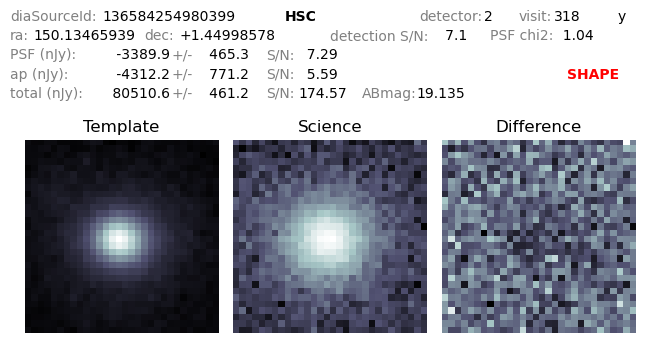

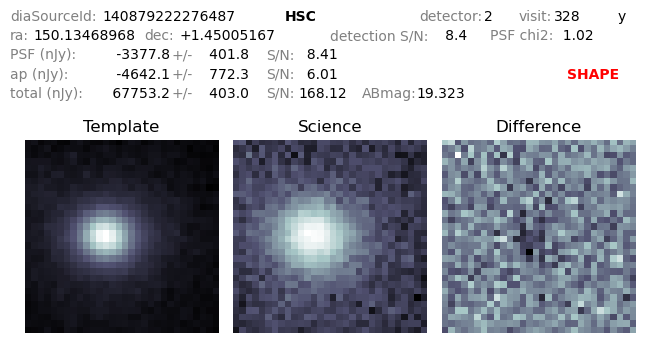

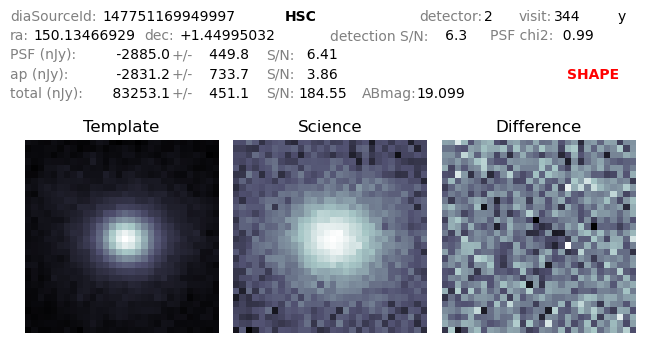

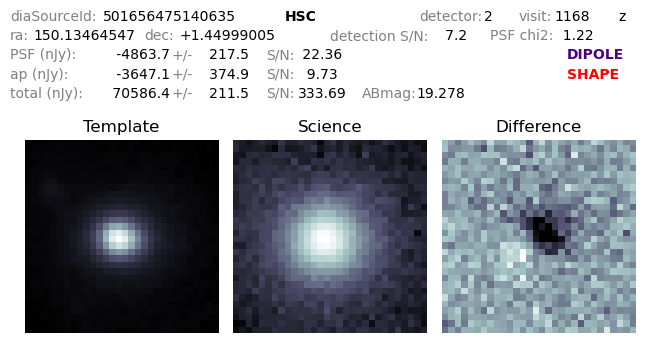

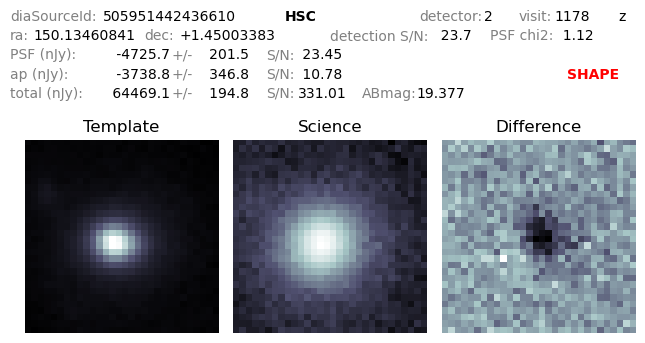

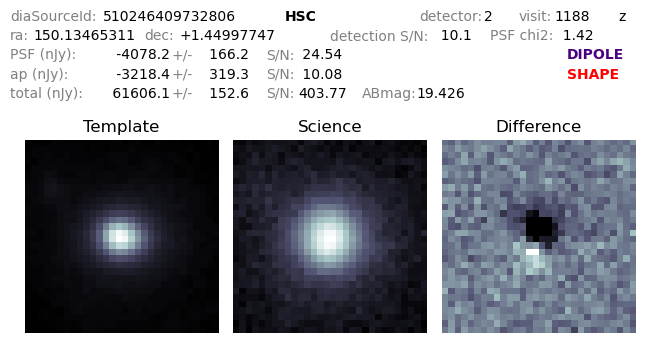

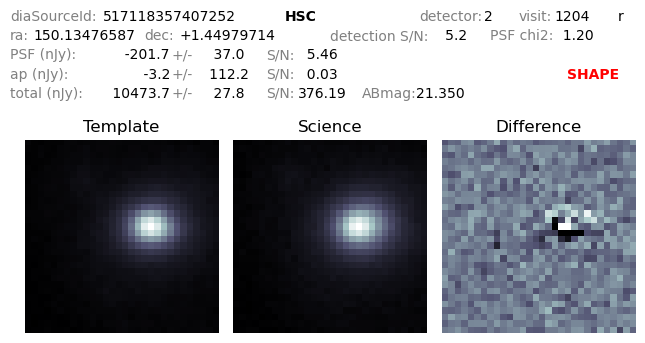

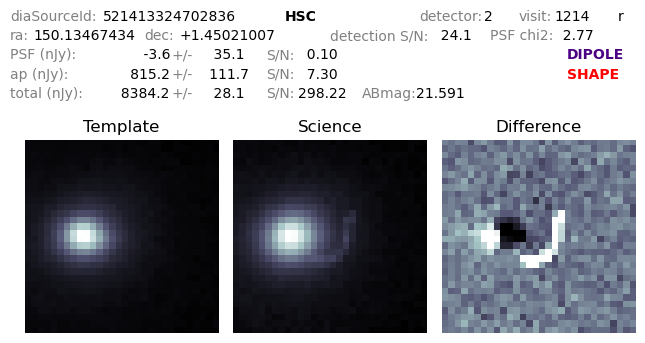

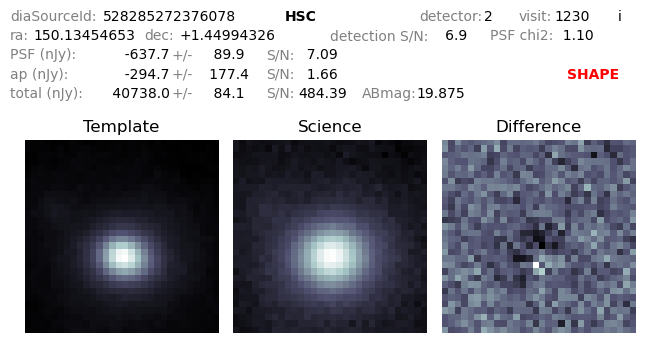

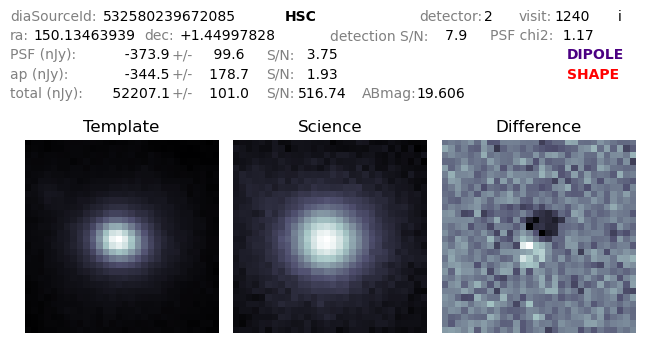

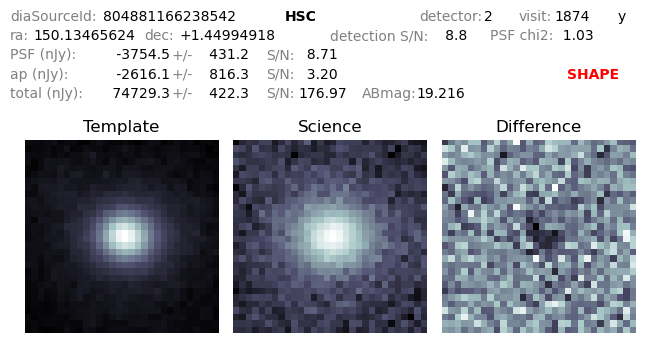

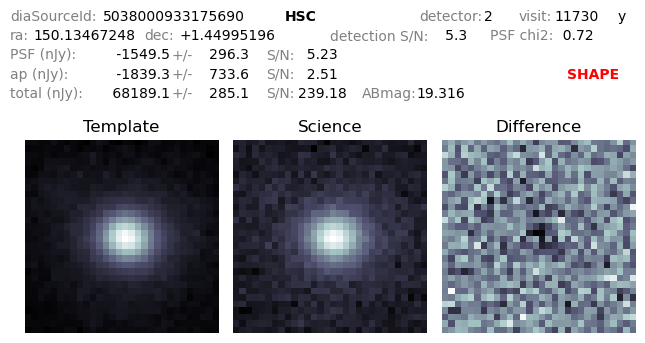

Path not found for 7688854748267220.
Path not found for 7700021663236623.
Path not found for 7702596496130573.
Path not found for 8443909998904096.
Path not found for 8458512887711011.
Path not found for 8464523694440885.
Path not found for 9719510990849026.
Path not found for 13095357432988211.
Path not found for 13097932265882822.
------ Now showing 18 sources for DiaObject 136584254980399 ------


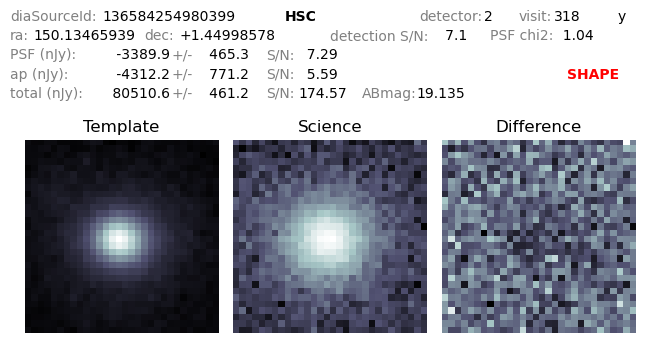

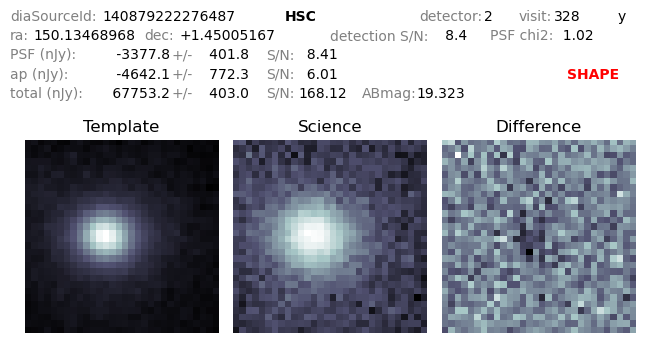

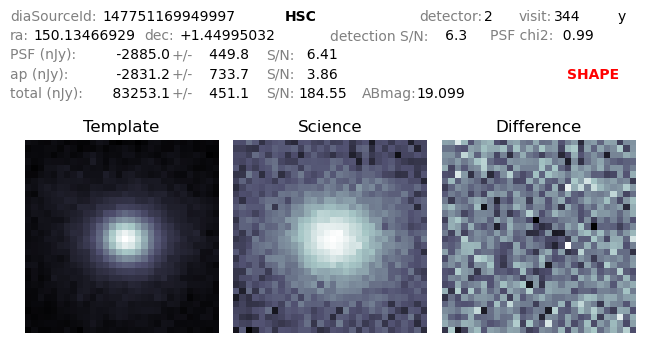

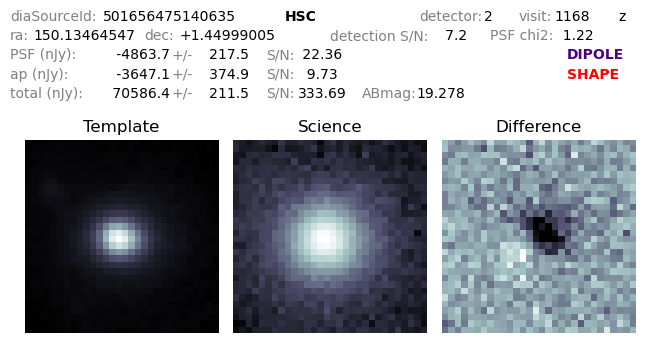

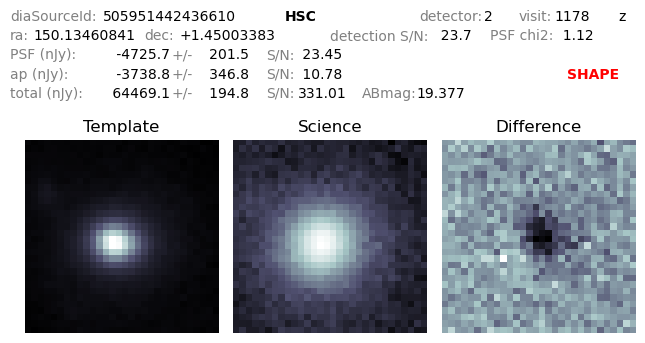

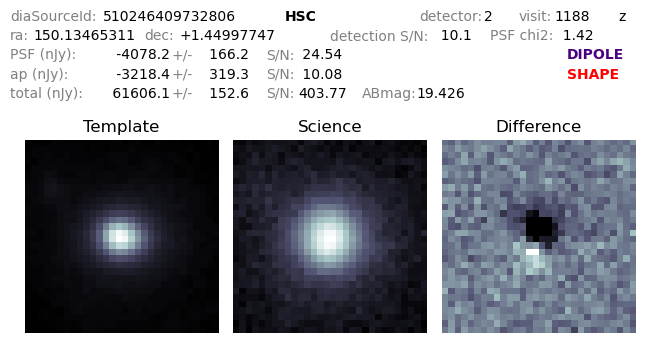

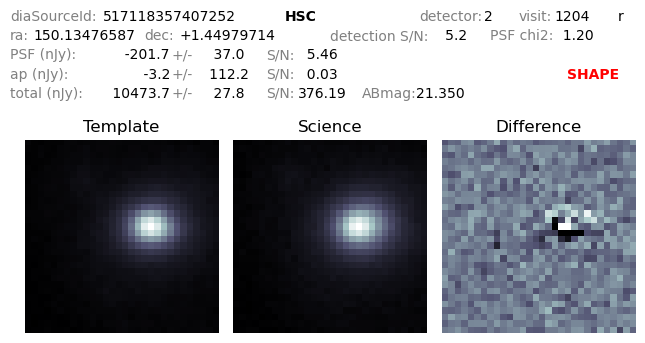

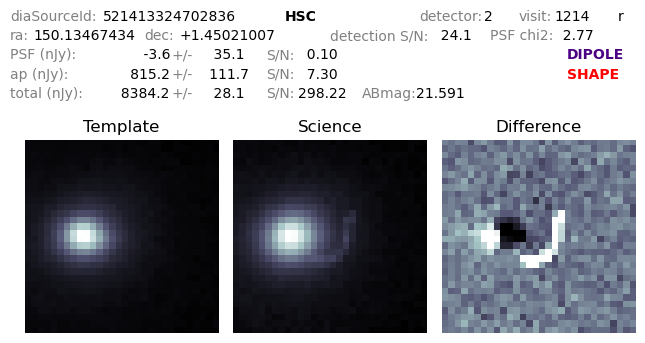

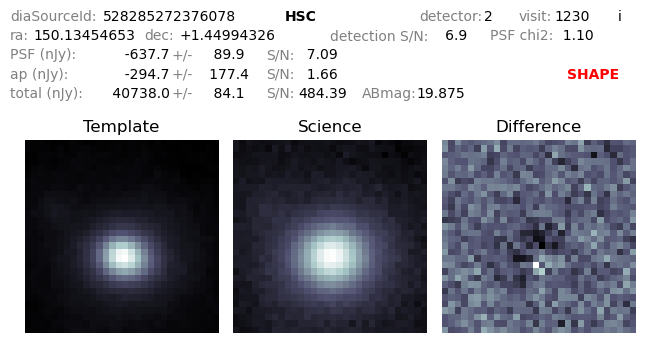

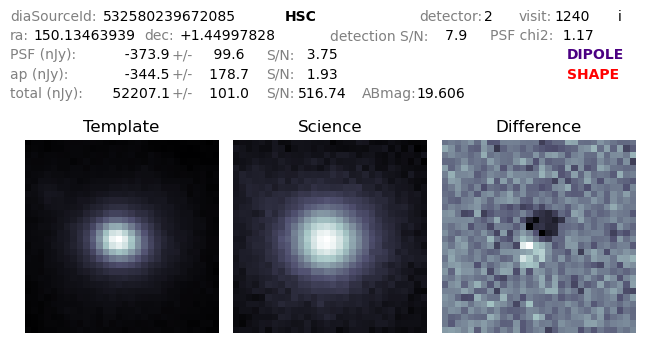

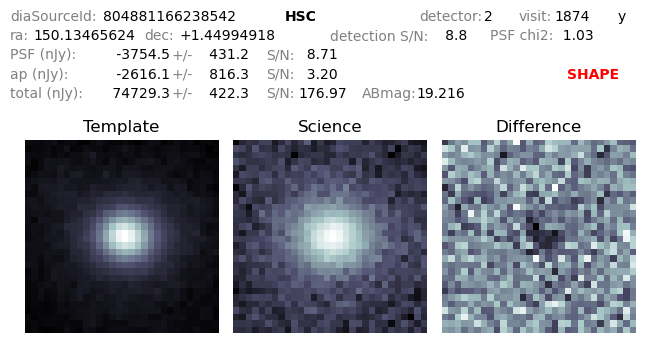

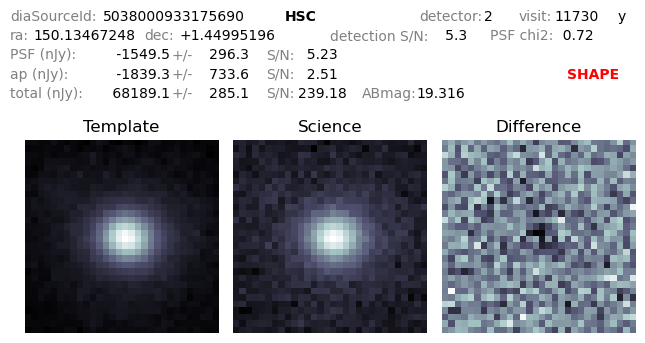

Path not found for 7688854748267220.
Path not found for 7700021663236623.
Path not found for 7702596496130573.
Path not found for 8443909998904096.
Path not found for 8458512887711011.
Path not found for 8464523694440885.
Path not found for 9719510990849026.
Path not found for 13095357432988211.
Path not found for 13097932265882822.
------ Now showing 13 sources for DiaObject 136584254980399 ------


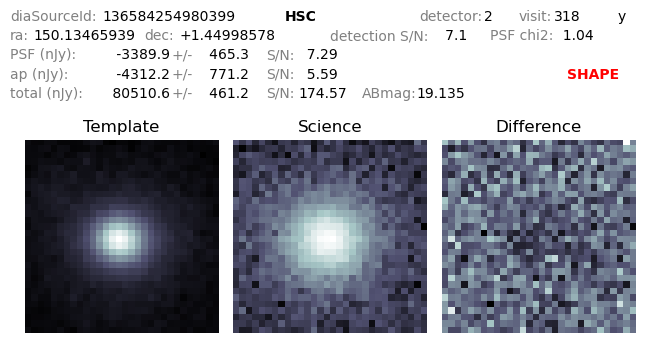

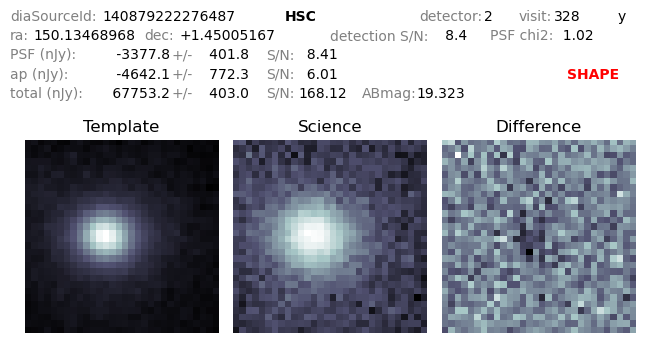

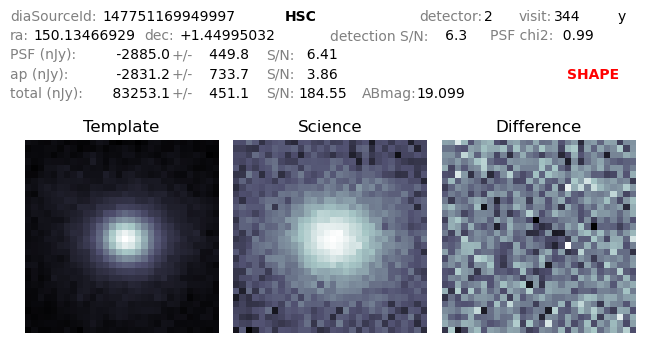

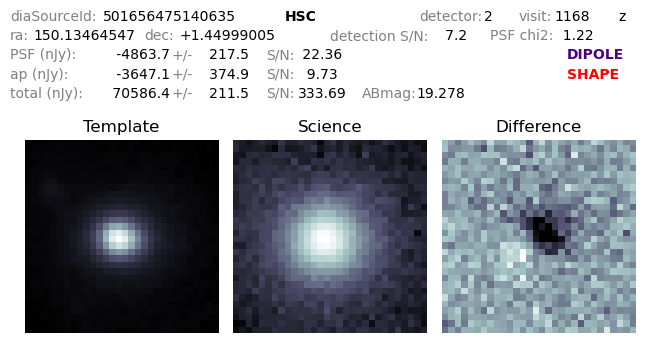

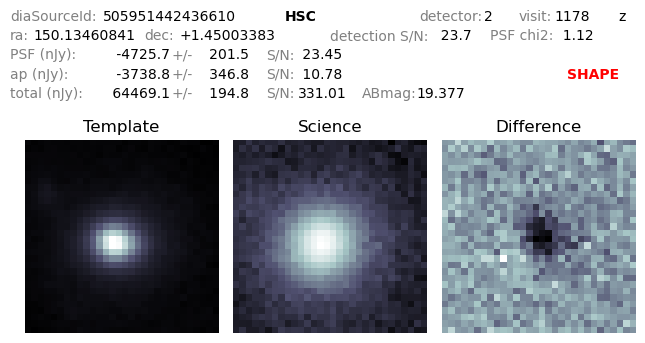

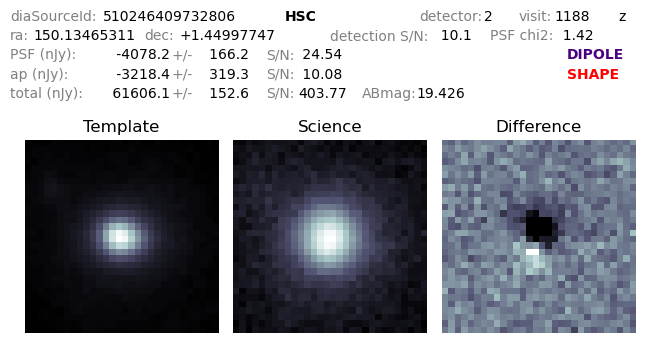

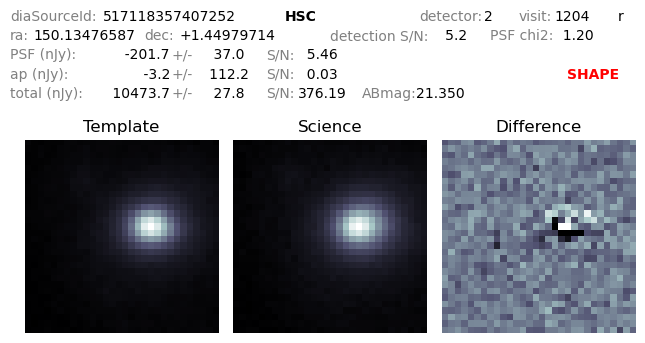

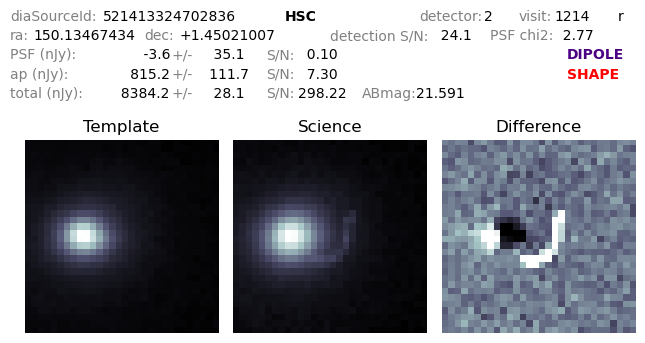

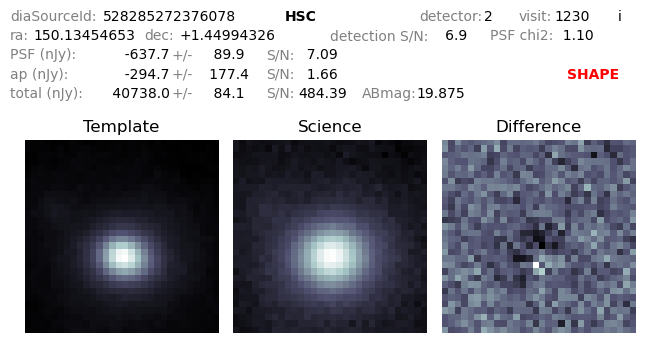

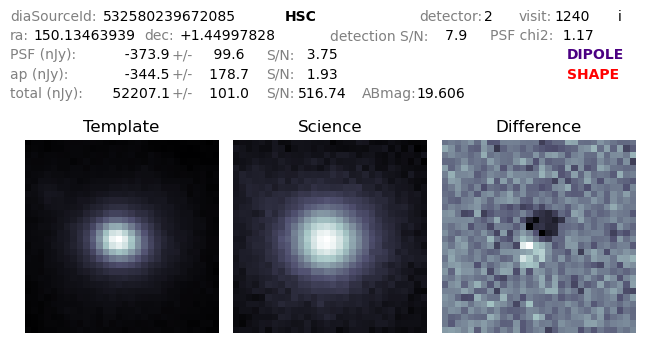

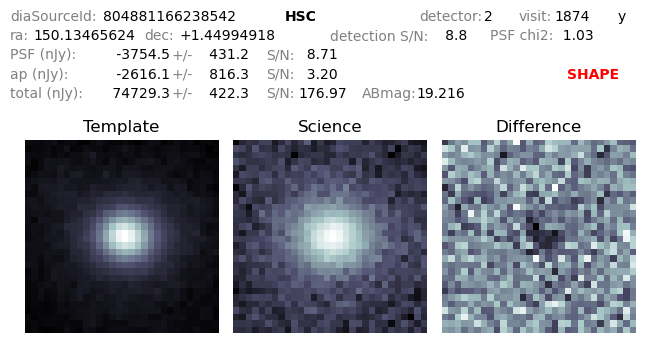

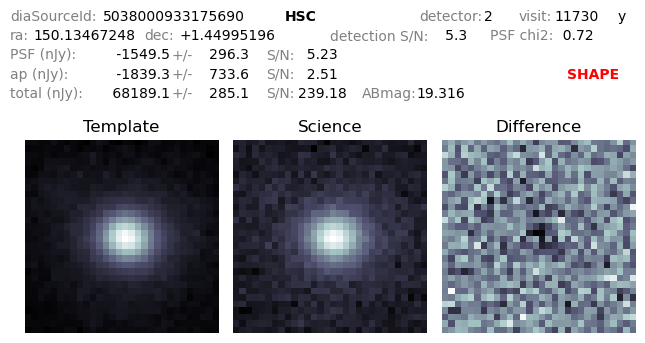

Path not found for 7688854748267220.
Path not found for 7700021663236623.
Path not found for 7702596496130573.
Path not found for 8443909998904096.
Path not found for 8458512887711011.
Path not found for 8464523694440885.
Path not found for 9719510990849026.
Path not found for 13095357432988211.
Path not found for 13097932265882822.


In [14]:
iobj=0
for myobj in myobjs.itertuples():
    print("------ Now showing {} sources for DiaObject {} ------".format(myobj.nDiaSources,
                                                                         myobj.diaObjectId))
    one_object = apdbQuery.load_sources_for_object(myobj.diaObjectId)
    for mysrc in one_object.itertuples():
        path = path_manager(mysrc.diaSourceId)
        if os.path.exists(path):
            try:
                display(Image(path))
            except:
                print("Failed to plot cutouts for {}.".format(mysrc.diaSourceId))
        else:
            print("Path not found for {}.".format(mysrc.diaSourceId))
    iobj += 1
    if iobj >= 3: break
    

In [15]:
one_object = apdbQuery.load_sources_for_object(529146413318969)

### Try to make a light curve for all sources in an object; optionally use only good sources

In [16]:
someobj = 136584254980399
goodOnly = True
one_object = apdbQuery.load_sources_for_object(someobj)

In [17]:
defaultBadFlagList = ['base_PixelFlags_flag_bad',
                      'base_PixelFlags_flag_suspect',
                      'base_PixelFlags_flag_saturatedCenter',
                      'base_PixelFlags_flag_interpolated',
                      'base_PixelFlags_flag_interpolatedCenter',
                      'base_PixelFlags_flag_edge',
                     ]

In [18]:
# function for plotting cutouts: add an additional option inside the light curve plot so that you are using the exact same table and cuts for both
def plotDiaObjectCutouts(diaObjectId, goodOnly=False, cutoutDir=None, badFlagList=None):
    """ plot cutouts for all sources associated to a given diaObject
    Parameters
    ----------
    diaObjectId: `int`
    goodOnly: `bool`, optional
    cutoutDir: `str`, optional
    badFlagList: `list`, optional
    Returns
    -------
    
    """
    path_manager = PathManager(cutoutDir, chunk_size=10000)
    if badFlagList is not None:
        apdbQuery.set_excluded_diaSource_flags(badFlagList)
    diaSources = apdbQuery.load_sources_for_object(diaObjectId, exclude_flagged=goodOnly)
    
    print("------ Now showing {} sources for DiaObject {} ------".format(len(diaSources),
                                                                         diaObjectId))
    for mysrc in diaSources.itertuples():
        path = path_manager(mysrc.diaSourceId)
        if os.path.exists(path):
            try:
                display(Image(path))
            except:
                print("Failed to plot cutouts for {}.".format(mysrc.diaSourceId))
        else:
            print("Path not found for {}.".format(mysrc.diaSourceId))
    

In [19]:
def plotDiaObjectLightCurve(diaObjectId, goodOnly=False, mode='flux',
                            plotCutouts=False, cutoutDir=None,
                            badFlagList=None):
    
    if mode not in ['flux', 'mag']:
        raise ValueError("Mode must be either 'flux' or 'mag'.")
    xlabel = "midPointTAI"
    ylabel = "Flux (nJy)"
    if badFlagList is not None:
        apdbQuery.set_excluded_diaSource_flags(badFlagList)
        
    one_object = apdbQuery.load_sources_for_object(diaObjectId,
                                                   exclude_flagged=goodOnly)
    if mode == 'mag':
        one_object['abMag'] = pd.Series((obj.totFlux*u.nJy).to(u.ABmag).value for obj in one_object.itertuples())
        one_object['abMagErr'] = pd.Series(afwImage.abMagErrFromFluxErr((obj.totFluxErr*u.nJy).value,
                                  (obj.totFlux*u.nJy).value) for obj in one_object.itertuples())
        val = one_object['abMag']
        valErr = one_object['abMagErr']
        ylabel='Mag'
    else:
        val = one_object['psFlux']
        valErr = one_object['psFluxErr']
    plt.scatter(one_object['midPointTai'],val)
    plt.errorbar(one_object['midPointTai'], val, yerr=valErr, fmt='o')
    if plotCutouts:
        plotDiaObjectCutouts(diaObjectId, goodOnly=goodOnly,
                             cutoutDir=cutoutDir, badFlagList=badFlagList)

------ Now showing 20 sources for DiaObject 136584254980399 ------


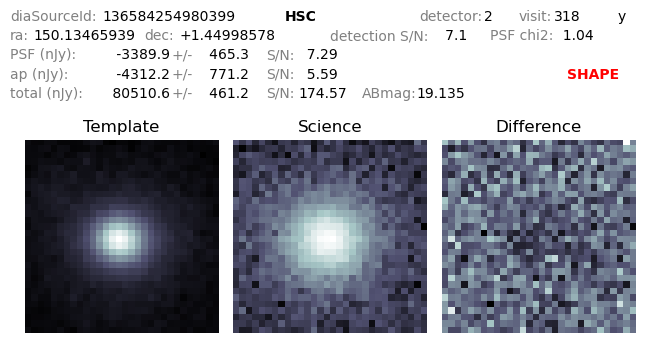

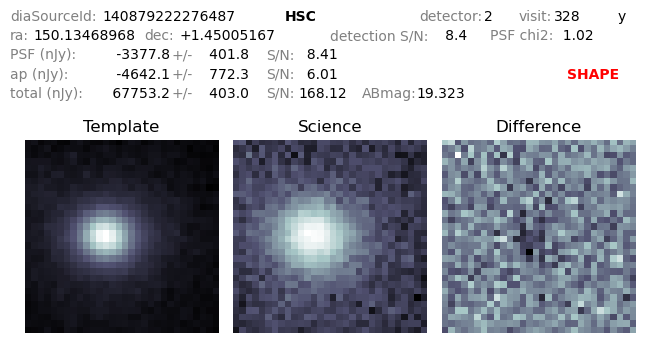

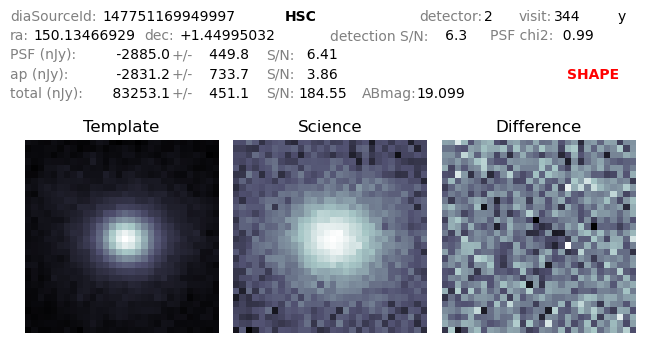

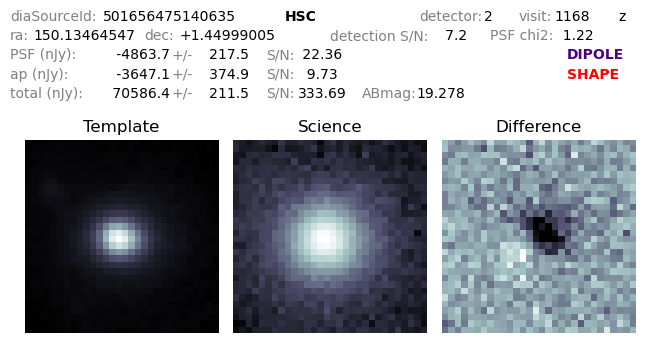

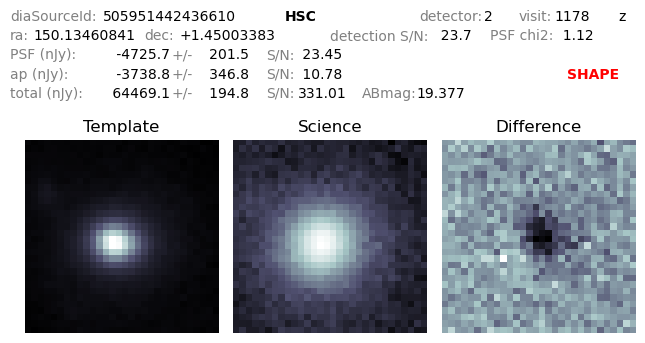

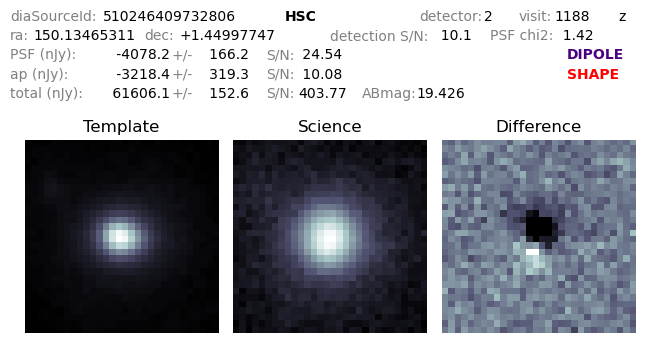

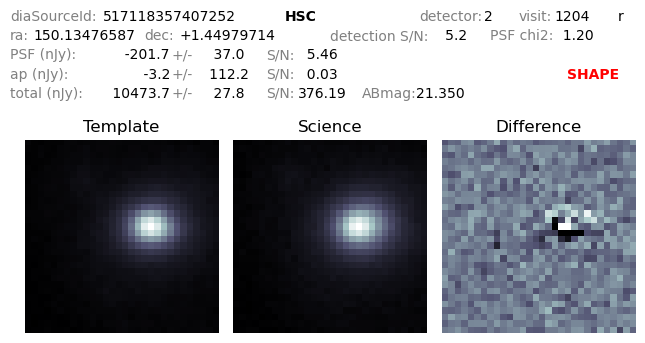

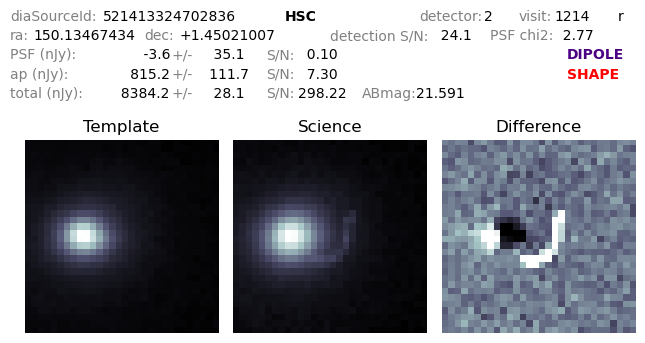

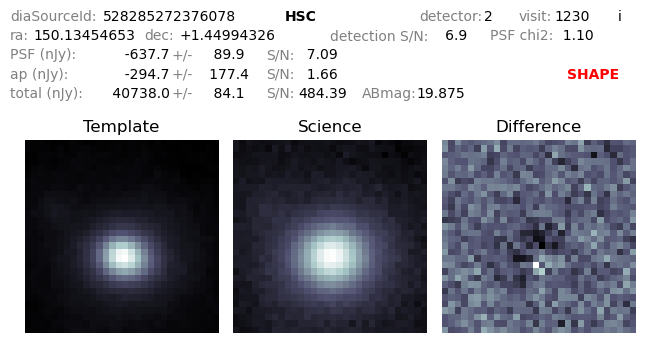

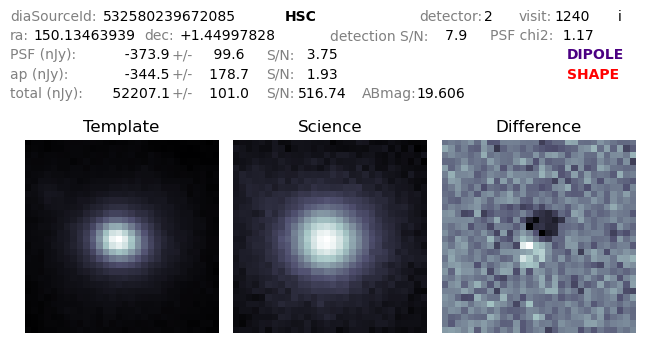

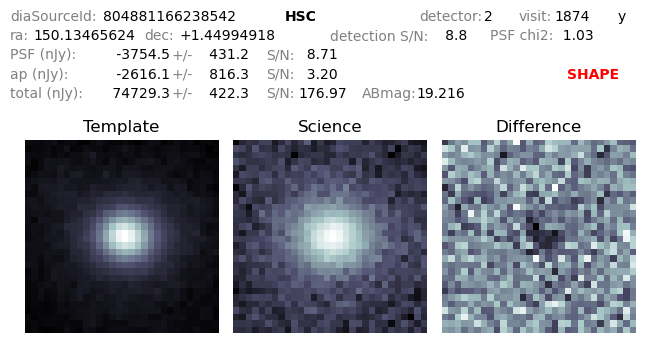

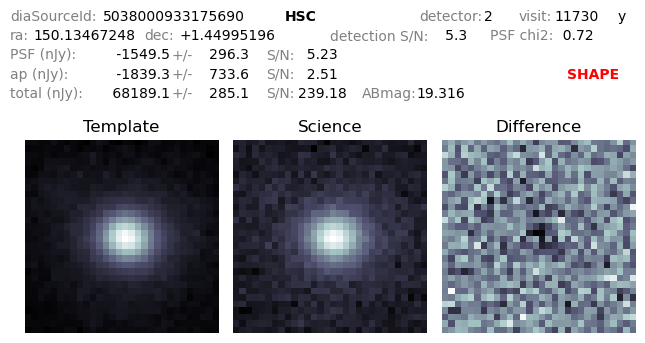

Path not found for 7688854748267220.
Path not found for 7700021663236623.
Path not found for 7702596496130573.
Path not found for 8443909998904096.
Path not found for 8458512887711011.
Path not found for 8464523694440885.
Path not found for 9719510990849026.
Path not found for 13095357432988211.


Text(0, 0.5, 'Mag')

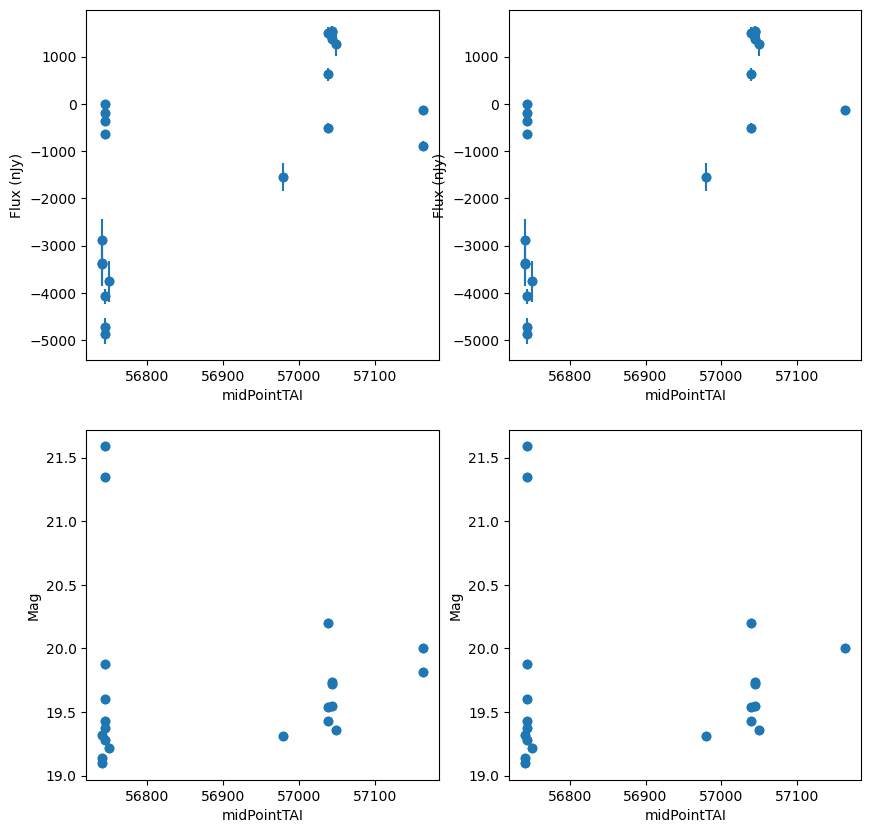

In [20]:
afig = plt.figure(figsize=(10,10))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=afig)
ax1 = afig.add_subplot(spec[0,0])
xlabel = "midPointTAI"
plotDiaObjectLightCurve(someobj, goodOnly=False, mode='flux',
                        plotCutouts=False,
                        cutoutDir="/sdf/group/rubin/u/parejko/scratch/cutouts")
ax1.set_xlabel(xlabel)
ax1.set_ylabel("Flux (nJy)")

ax2 = afig.add_subplot(spec[0,1])
plotDiaObjectLightCurve(someobj, goodOnly=True, mode='flux',
                        plotCutouts=True,
                        cutoutDir="/sdf/group/rubin/u/parejko/scratch/cutouts",
                        badFlagList=defaultBadFlagList)
ax2.set_xlabel(xlabel)
ax2.set_ylabel("Flux (nJy)")

ax3 = afig.add_subplot(spec[1,0])
plotDiaObjectLightCurve(someobj, goodOnly=False, mode='mag')
ax3.set_xlabel(xlabel)
ax3.set_ylabel("Mag")

ax4 = afig.add_subplot(spec[1,1])
plotDiaObjectLightCurve(someobj, goodOnly=True, mode='mag',
                        badFlagList=defaultBadFlagList)
ax4.set_xlabel(xlabel)
ax4.set_ylabel("Mag")

Not currently used, but potentially useful in the future...

In [21]:
def addFlags(sourceTable):
    config = TransformDiaSourceCatalogConfig()
    unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
    flagValues = unpacker.unpack(sourceTable['flags'], 'flags')
    flagTable = pd.DataFrame(flagValues, index=sourceTable.index)
    sourceTableFlags = pd.merge(diaSources, flagTable, left_index=True, right_index=True)
    return sourceTableFlags

------ Now showing 20 sources for DiaObject 136584254980399 ------


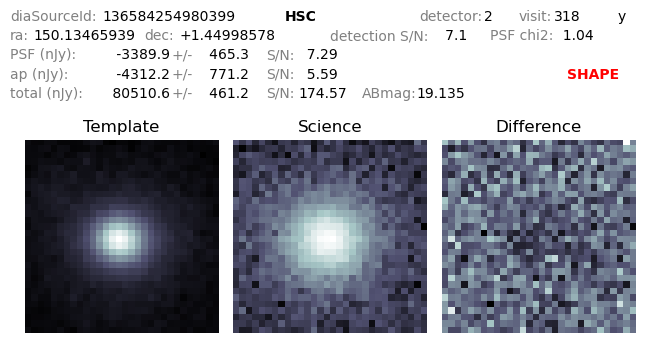

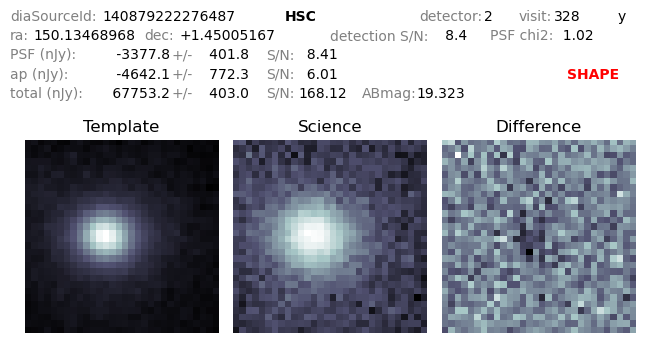

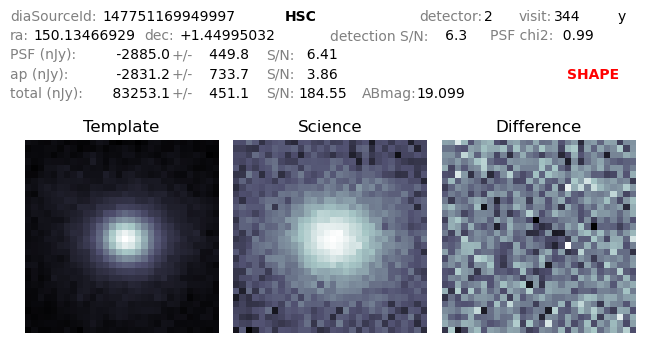

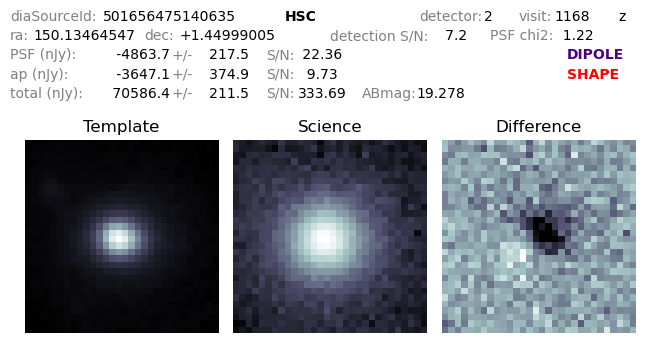

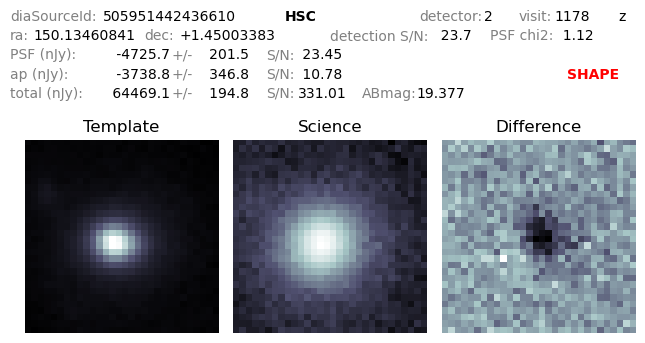

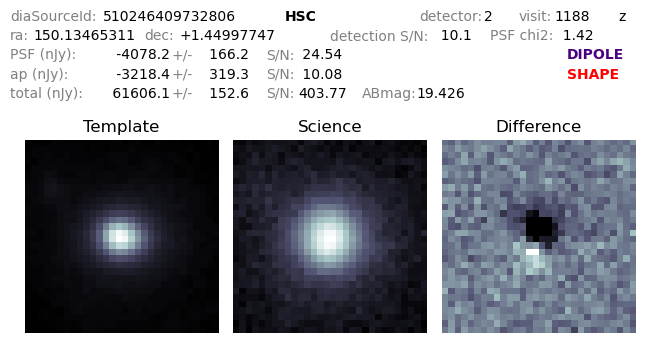

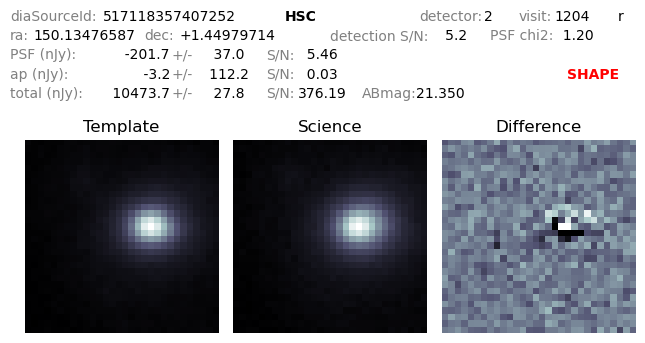

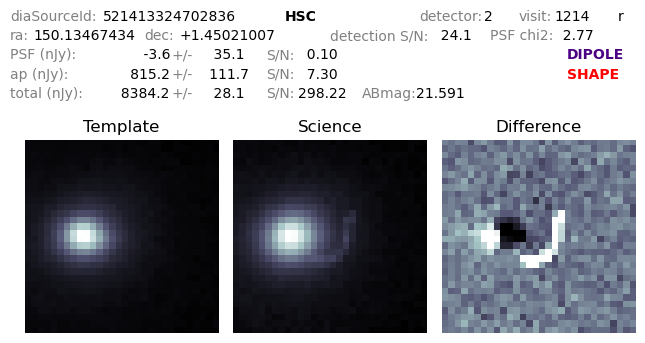

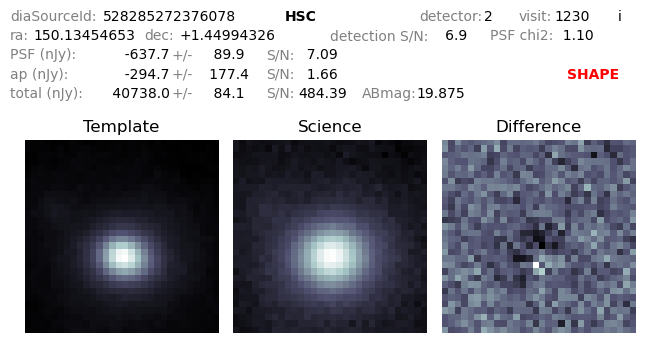

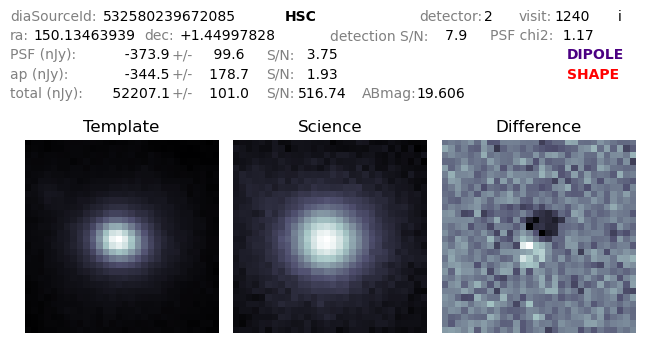

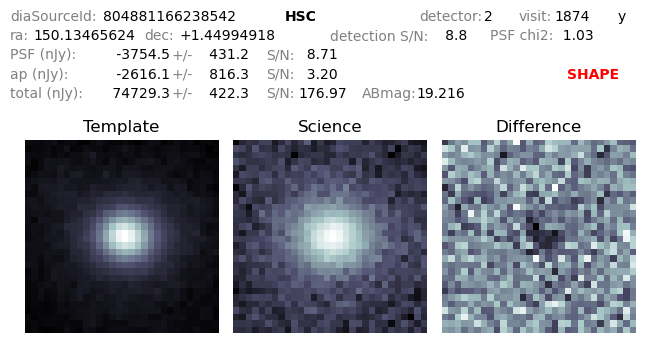

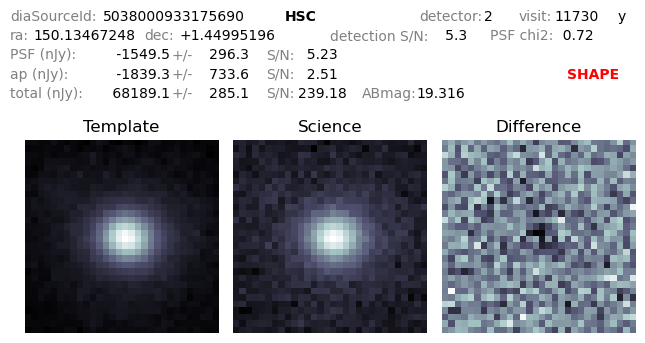

Path not found for 7688854748267220.
Path not found for 7700021663236623.
Path not found for 7702596496130573.
Path not found for 8443909998904096.
Path not found for 8458512887711011.
Path not found for 8464523694440885.
Path not found for 9719510990849026.
Path not found for 13095357432988211.


In [22]:
plotDiaObjectCutouts(someobj, goodOnly=True,
                     cutoutDir="/sdf/group/rubin/u/parejko/scratch/cutouts",
                    badFlagList=defaultBadFlagList)